In [75]:
# libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time
import torch
from tqdm import tqdm
from preprocessing import extract_data_mooc, extractFeatures,extractItemUserId,extractNextStateItem,extractNextUserState,UserNextInteraction, delta, t_batch_update,train_test_split,train_test_stratified_split
from model import RODIE,dynamic_embedding
from sklearn.manifold import TSNE
from train import train_rodie

In [3]:
## Téléchargement des données
!wget https://snap.stanford.edu/data/act-mooc.tar.gz
!tar -xzf  act-mooc.tar.gz
!mkdir data

--2022-03-17 10:41:00--  https://snap.stanford.edu/data/act-mooc.tar.gz
Resolving snap.stanford.edu (snap.stanford.edu)... 171.64.75.80
Connecting to snap.stanford.edu (snap.stanford.edu)|171.64.75.80|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5378133 (5.1M) [application/x-gzip]
Saving to: ‘act-mooc.tar.gz’

act-mooc.tar.gz     100%[===================>]   5.13M  4.89MB/s    in 1.0s    

2022-03-17 10:41:01 (4.89 MB/s) - ‘act-mooc.tar.gz’ saved [5378133/5378133]



In [76]:
features = pd.read_csv("act-mooc/mooc_action_features.tsv",sep="\t")
labels = pd.read_csv("act-mooc/mooc_action_labels.tsv",sep="\t")
users = pd.read_csv("act-mooc/mooc_actions.tsv",sep="\t")

#### Load & Preprocess Data

In [77]:
mooc_data = extract_data_mooc()

delta_u  = delta(mooc_data.copy(),"user_id")
delta_i  = delta(mooc_data.copy(),"item_id")
nextItemInteraction = UserNextInteraction(mooc_data.copy())
next_state_user = extractNextUserState(mooc_data.copy())


mooc_data['delta_u'] = delta_u/np.std(delta_u)
mooc_data['delta_i'] = delta_i/np.std(delta_i)
mooc_data['nextItemInteraction'] = nextItemInteraction
mooc_data['next_state_user'] = next_state_user

data = mooc_data.copy()
data = data[ (data.nextItemInteraction != -1) | (data.next_state_user != -1)  ]

data = data[['user_id', 'item_id', 'timestamp', 'state_label','delta_u', 'delta_i', 'nextItemInteraction', 'next_state_user','f1', 'f2', 'f3','f4']]
data.head()

delta user_id
delta item_id


,user_id,item_id,timestamp,state_label,delta_u,delta_i,nextItemInteraction,next_state_user,f1,f2,f3,f4
ACTIONID,,,,,,,,,,,,
0,0,0,0.0,0,0.000000,0.000000,1,0,-0.319991,-0.435701,0.106784,-0.067309
1,0,1,6.0,0,0.000064,0.000000,2,0,-0.319991,-0.435701,0.106784,-0.067309
2,0,2,41.0,0,0.000372,0.000000,1,0,-0.319991,-0.435701,0.106784,-0.067309
3,0,1,49.0,0,0.000085,0.007652,2,0,-0.319991,-0.435701,0.106784,-0.067309
4,0,2,51.0,0,0.000021,0.001780,3,0,-0.319991,-0.435701,0.106784,-0.067309


### T-batches

#### Train / Test SPLIT

In [78]:
df_train1,df_test1 = train_test_stratified_split(data)
df_train2,df_test2 = train_test_stratified_split(df_test1)
df_train3,df_test = train_test_stratified_split(df_test2)

StratifiedKFold(n_splits=2, random_state=None, shuffle=False)
StratifiedKFold(n_splits=2, random_state=None, shuffle=False)
StratifiedKFold(n_splits=2, random_state=None, shuffle=False)


In [79]:
df_train = pd.concat([df_train1],axis=0)
df_train.shape,df_test.shape

((202351, 12), (50587, 12))

In [80]:
print("Proportion of dropout user in :\n Train data = {:.1f}%\n Test Data= {:.1f}%".format(100*np.sum(df_train['next_state_user'])/df_train.shape[0],100*np.sum(df_test['next_state_user'])/df_test.shape[0]))

Proportion of dropout user in :
 Train data = 1.0%
 Test Data= 1.0%


In [81]:
t_batches_train = t_batch_update(df_train)
t_batches_test = t_batch_update(df_test)

T-Batch start...
Number of interaction = 202351
T-Batch ends !
T-Batch start...
Number of interaction = 50587
T-Batch ends !


##### Initialize Device

In [82]:
# setting device on GPU if available, else CPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
#device = "cpu"
print('Using device:', device)

Using device: cuda


##### Initialize the model

In [101]:
# Its important to add this to the loss, because the dataset is unbalanced
dropout_ratio = len(df_train['next_state_user'])/(1+np.sum(df_train['next_state_user']))
weight_ratio = torch.Tensor([1,dropout_ratio]).to(device)
print(weight_ratio)

tensor([ 1.0000, 99.4843], device='cuda:0')


##### Train Loop

In [241]:
import torch
from  torch import nn
from torch.nn import RNNCell
from torch.nn.functional import one_hot
import math
from torch.nn import functional as F


## This custom class of Linear, enables to initialize the weights of the layer to belong to a normal distribution ##

class NormalLinear(nn.Linear):
    def reset_parameters(self):
        stdv = 1. / math.sqrt(self.weight.size(1))
        self.weight.data.normal_(0, stdv)
        if self.bias is not None:
            self.bias.data.normal_(0, stdv)

## This function enables to create the dynamic embedding of each node ##
def dynamic_embedding(data,embedding_dim):
        num_users = len(torch.unique(data[:,0]))
        num_items = len(torch.unique(data[:,1]))
        dynamic_users_embedding = F.normalize(torch.randn(num_users,embedding_dim))
        dynamic_items_embedding = F.normalize(torch.randn(num_items,embedding_dim))

        print("Initialisation of dynamic embedding... Done !")
        print("Dynamic Embedding shape : Users {}, \t Items {}".format(list(dynamic_users_embedding.size()),list(dynamic_items_embedding.size())))

        return dynamic_users_embedding,dynamic_items_embedding
        

class RODIE(torch.nn.Module):

    def __init__(self,embedding_dim,data,device,activation_rnn="relu",MLP_h_dim=50,option="user_state"):
        super(RODIE, self).__init__()
        self.option = option
        self.embedding_dim = embedding_dim
        self.activation_rnn = activation_rnn
        self.data = data
        self.MLP_h_dim = MLP_h_dim  # The dimension of the hidden layer of the MLP used for the classification of Users 
        # Select features of the data
        self.features = self.data[:,8:]
        self.dim_features = self.features.shape[1]
        # Number of users and number of items
        num_users = len(torch.unique(data[:,0]))

        num_items = len(torch.unique(data[:,1]))


        print("Number of users of {} \n Number of items {} \n".format(num_users,num_items))
        print("Dataset size {}".format(list(self.data.size())))
        # Initialize static  embeddings
        self.static_users_embedding = one_hot(torch.arange(0,num_users))
        self.static_items_embedding = one_hot(torch.arange(0,num_items))
        static_user_embedding_dim = self.static_users_embedding.shape[1]
        static_item_embedding_dim = self.static_items_embedding.shape[1]
        print("Initialisation of static embedding... Done !")
        print("Static Embedding shape : Users {}, \t Items {}".format(list(self.static_users_embedding.size()),list(self.static_items_embedding.size())))

        # Initialize dynamic  embeddings
        # In JODIE official implementation, authors decided to attribute the SAME initial dynamic embedding 
        



        input_rnn_user_dim =  self.embedding_dim + self.dim_features + 1

        input_rnn_item_dim =  self.embedding_dim + self.dim_features + 1

        self.item_rnn = RNNCell(input_rnn_user_dim, self.embedding_dim, nonlinearity = self.activation_rnn)


        self.user_rnn = RNNCell(input_rnn_item_dim,self.embedding_dim, nonlinearity = self.activation_rnn)

        print("Initialisation of rnn's with {} activation function... Done !".format(self.activation_rnn))

        # Projection layer -> projection operation   
        self.projection_layer = NormalLinear(1,self.embedding_dim, bias=False)
        # Predict next item embedding layer
        self.predictItem_layer = nn.Linear(static_item_embedding_dim + static_user_embedding_dim  + 2*self.embedding_dim, static_item_embedding_dim + self.embedding_dim, bias=True)

        self.predictStateUser_MLP = torch.nn.Sequential(
            nn.Linear(self.embedding_dim,self.MLP_h_dim),
            torch.nn.ReLU(),
            nn.Linear(self.MLP_h_dim,2),
          #  torch.nn.Softmax(dim=1)
            )
        print("Initialisation of MLP... Done !")


    ######## Predicting next item embedding  ########
    def update_item_rnn(self,
                          dynamic_item_embedding, # at t-1
                          dynamic_user_embedding,# at t-1
                          features,
                          delta_i,
):

      concat_input = torch.concat([
                                  dynamic_user_embedding,
                                  delta_i.reshape(-1,1),
                                  features,
      ],axis=1)
      return F.normalize(self.item_rnn(concat_input,dynamic_item_embedding))



    ######## Predicting next user embedding  ########
    def update_user_rnn(self,
                        dynamic_user_embedding, # at t-1
                        dynamic_item_embedding,# at t-1
                        features,
                        delta_u):
      concat_input = torch.concat([
                                  dynamic_item_embedding,
                                  delta_u.reshape(-1,1),
                                   features],
                                  axis=1)
      return F.normalize(self.user_rnn(concat_input,dynamic_user_embedding))

    

    ######## Projecting the embedding the new dynamic embedding of the user at a future time  ########
    def projection_operation(self,
                            dynamic_user_embedding,
                            delta_u):
        u_projection =  dynamic_user_embedding * (1 + self.projection_layer(delta_u.reshape(-1,1)))

        return u_projection
        
    ######## Predicting next potential item, the specific user will interact with  ########
    
    def predict_item_embedding(self,
        u_projection,
        u_static,
        i_dynamic,
        i_static
        ):
        concatenated_input = torch.concat([u_projection,i_dynamic,i_static,u_static],axis=1)
        j_tilde = self.predictItem_layer(concatenated_input)
        return j_tilde

    ######## Predicting next user state  ########

    def predict_user_state(self,dynamic_user_embedding):
        u_state = self.predictStateUser_MLP(dynamic_user_embedding)

        return u_state

    def forward(self,
                actual_item_embedding,
                actual_user_embedding,
                u_static,
                i_static,
                f,
                delta_u,
                delta_i,
                next_state_label,
                next_item_dynamic_embedding,
                next_item_static_embedding
                ):
      ######## New  Dynamic Embeddings ########
      # New dynamic embedding of the user
      future_user_embedding= self.update_user_rnn(actual_user_embedding,actual_item_embedding,f,delta_u)
      # New dynamic embedding of the item
      future_item_embedding= self.update_item_rnn(actual_item_embedding,actual_user_embedding,f,delta_i)     


      # Projection of the user

      projected_user_embedding = self.projection_operation(future_user_embedding,delta_u)

      # Predict next item
      j_tilde = self.predict_item_embedding(
        projected_user_embedding,
        u_static,
        future_item_embedding,
        i_static)
      
      # The real next item embedding j_true, is the concatenation of the static and dynamic embedding of the next item 
      j_true = torch.concat([next_item_dynamic_embedding,next_item_static_embedding],axis=1).detach()
        # Prediction of next state of the user using an MLP at the end
      U_pred_state = self.predict_user_state(future_user_embedding)

      return future_user_embedding,future_item_embedding,U_pred_state,j_tilde,j_true


In [249]:

from torch.nn import MSELoss, HuberLoss,L1Loss,CrossEntropyLoss
from preprocessing import *
import torch
from  torch import nn
from torch.nn import RNNCell
from torch.nn.functional import one_hot
import math
from tqdm import tqdm
from torch.nn import MSELoss, HuberLoss,L1Loss,CrossEntropyLoss
from torch.nn import functional as F

def regularizer(actual_user_embedding,future_user_embedding,lambda_u,
                               actual_item_embedding,future_item_embedding,lambda_i
                               ):
    u_regularization_loss =  MSELoss()(actual_user_embedding,future_user_embedding)
    i_regularization_loss =  MSELoss()(actual_item_embedding,future_item_embedding)
    return lambda_u* u_regularization_loss + lambda_i* i_regularization_loss 


def train_rodie(t_batches,
          data,
          U,
          I,
          weight_ratio,
          model,
          optimizer,
          learning_rate,
          n_epochs,
          lambda_u,
          lambda_i,
          device,

          ):
  print("Training...")
 # U_copy = U.clone().detach()
 # I_copy = I.clone().detach()
  scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min')
  for e in range(n_epochs):
    l = 0
    
    for (_,rows),_ in zip(t_batches.items(),tqdm(range(len(t_batches)), position=0, leave=True)):
      optimizer.zero_grad()
      users_idx,items_idx = extractItemUserId(data,rows)

      state_label,delta_u,delta_i,f = extractFeatures(data,rows)

      next_state,next_item = extractNextStateItem(data,rows)

      u_static, i_static = model.static_users_embedding[users_idx], model.static_items_embedding[items_idx]

      user_embedding, item_embedding = U[users_idx], I[items_idx]
      next_item_static_embedding, next_item_dynamic_embedding = model.static_items_embedding[[int(x) for x in next_item]], I[[int(x) for x in next_item]]

     # next_state = next_state.type(torch.LongTensor).to(device)
      item_embedding = item_embedding.to(device)
      user_embedding  = user_embedding.to(device)
      u_static = u_static.to(device)
      i_static = i_static.to(device)
      f = f.to(device)
      delta_u = delta_u.to(device)
      delta_i = delta_i.to(device)
      next_state = next_state.type(torch.LongTensor).to(device)
      next_item_dynamic_embedding = next_item_dynamic_embedding.to(device)
      next_item_static_embedding = next_item_static_embedding.to(device)
      
      # The forward pass of the model : extract dynamic embeddings (user+item ), and predicted user state and predicted item embedding
      future_user_embedding,future_item_embedding,U_pred_state,j_tilde,j_true  = model(item_embedding,
                user_embedding,
                u_static,
                i_static,
                f,
                delta_u,
                delta_i,
                next_state,
                next_item_dynamic_embedding,
                next_item_static_embedding)
      # Add the new embedding to the placeholder U and I
      U[users_idx] = future_user_embedding.detach().clone()
      I[items_idx] = future_item_embedding.detach().clone() 
      
      # Return loss value between the predicted embedding "j_tilde" and the real next item embedding j_true
      loss = MSELoss()(j_tilde,j_true)#.detach()
      loss += regularizer(user_embedding,future_user_embedding,lambda_u,
                            item_embedding,future_item_embedding,lambda_i
                            )
        
      loss += CrossEntropyLoss(weight_ratio)(U_pred_state,next_state)

      #print(I[0])
      loss.backward()
      l += loss.item()
      torch.nn.utils.clip_grad_norm_(model.parameters(),max_norm=10.)
      optimizer.step()
    print(loss.grad)#print(I[0])

    scheduler.step(loss)
    print("Epoch {} Loss {}".format(e,l))

  return model,U,I


In [250]:
# Test le modèle sur peu de données
import itertools
t_batches_ = dict(itertools.islice(t_batches_train.items(), 10000))

In [251]:
embedding_dim = 32
data_torch = torch.from_numpy(data.values.astype(np.float32))
U_dynamic,I_dynamic = dynamic_embedding(data_torch,embedding_dim)  # Initial dynamic embedding
    
U_dynamic = U_dynamic.to(device)
I_dynamic = I_dynamic.to(device)

model = RODIE(embedding_dim,data_torch,device=device,activation_rnn="tanh").to(device)

Initialisation of dynamic embedding... Done !
Dynamic Embedding shape : Users [7047, 32], 	 Items [97, 32]
Number of users of 7047 
 Number of items 97 

Dataset size [404702, 12]
Initialisation of static embedding... Done !
Static Embedding shape : Users [7047, 7047], 	 Items [97, 97]
Initialisation of rnn's with tanh activation function... Done !
Initialisation of MLP... Done !


In [252]:
n_epochs = 10
lambda_u = 1
lambda_i = 1
learning_rate=1e-3
optimizer = torch.optim.Adam(model.parameters(),lr=learning_rate,weight_decay=1e-5)

model_,U,I = train_rodie(t_batches_,
          data_torch,
          U_dynamic,
          I_dynamic,
          weight_ratio,
          model,
          optimizer,
          learning_rate,
          n_epochs,
          lambda_u,
          lambda_i,
          device
          )

Training...


100%|█████████▉| 9999/10000 [01:35<00:00, 104.51it/s]
/usr/local/lib/python3.7/dist-packages/torch/_tensor.py:1013: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at  aten/src/ATen/core/TensorBody.h:417.)
  return self._grad


None
Epoch 0 Loss 2146.34284730535


100%|█████████▉| 9999/10000 [01:36<00:00, 104.04it/s]


None
Epoch 1 Loss 2077.783149469644


100%|█████████▉| 9999/10000 [01:34<00:00, 105.30it/s]


None
Epoch 2 Loss 2073.6132218567654


100%|█████████▉| 9999/10000 [01:35<00:00, 104.43it/s]


None
Epoch 3 Loss 2064.042458511889


100%|█████████▉| 9999/10000 [01:33<00:00, 106.52it/s]


None
Epoch 4 Loss 2077.515445749741


100%|█████████▉| 9999/10000 [01:34<00:00, 106.29it/s]


None
Epoch 5 Loss 2074.506447300315


100%|█████████▉| 9999/10000 [01:33<00:00, 106.42it/s]


None
Epoch 6 Loss 2080.770323418081


100%|█████████▉| 9999/10000 [01:33<00:00, 107.08it/s]


None
Epoch 7 Loss 2075.267220833339


100%|█████████▉| 9999/10000 [01:33<00:00, 107.38it/s]


None
Epoch 8 Loss 2067.784402128309


100%|█████████▉| 9999/10000 [01:32<00:00, 107.58it/s]

None
Epoch 9 Loss 2065.573509281501


## TSNE

In [253]:
l = []
for x,y in t_batches_.items():
  l.append(y)


dd = sum(l, [])
ff = data.iloc[dd,:].copy()
list_of_change = ff[ff['next_state_user'] == 1]['user_id'].values


data_  = (U.detach().cpu().clone()).numpy()

list_of_change = ff[ff['next_state_user'] == 1]['user_id'].values

In [254]:
len(list_of_change)

543

In [255]:
df = pd.DataFrame(data_)
df['label'] = np.zeros((7047,1))

for index, row in df.iterrows():
    for d in list_of_change:
      if index == d:
        df.iloc[index,-1] = 1


In [257]:
from sklearn.decomposition import KernelPCA
tsne = KernelPCA(2)

data_tsne = tsne.fit_transform(data_)

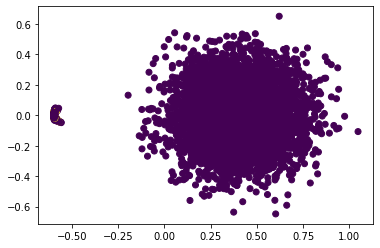

In [258]:
plt.scatter(data_tsne[:,0],data_tsne[:,1],c=df['label'],)

In [259]:
L = df[df['label'] == 1.0].index.values

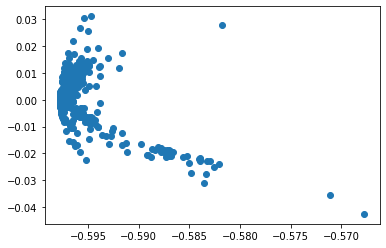

In [260]:
plt.scatter(data_tsne[L,0],data_tsne[L,1])

In [113]:
np.sum(df['label'])

2291.0

In [73]:
l = df[df['label']==1.0].index.values

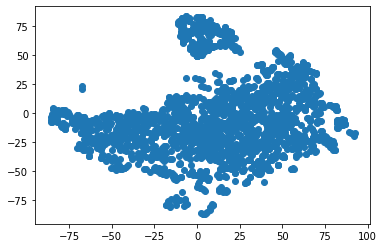

In [74]:
plt.scatter(data_tsne[l,0],data_tsne[l,1])

In [66]:
np.sum(df['label'])

2291.0